Training space of words with CBoW model
=============
<span style="color: lightsteelblue;">Resulting embeddings are used in the pretrained RNN LSTM model.</span>

The goal of this notebook is to train a Word2Vec *CBoW* model over <span style="color: red;">some(?)</span> data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from pathlib import Path
import pickle
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE
from IPython.display import clear_output

# custom libraries
from nlp.preparer import Corpus

Build the dictionary and replace rare words with UNK token.

In [2]:
# corpora_paths = ['./articles/good.articles', './articles/bad.articles']
corpora_paths = ['./articles/wiki_00', './articles/wiki_01']
corpora = []
lengths = []

for path in corpora_paths:
  corpus = Corpus(path, stemming=False)
  corpora.append(corpus)
  length = [len(article) for article in corpus.articles]
  lengths.append(length)

  print(f"Corpus label: {corpus.label}, ",
        f"length: {len(corpus.articles)} articles, ",
        f"av length: {round(corpus.average_length())} words, ",
        f"max length: {max(length)} words.")
  print(f"Corpus raw article: {corpus.raw[0][:200]}")
  print(f"Corpus data (words): {corpus.articles[0][:20]}\n")

# flatten all words into a single bag
all_words = [word for corpus in corpora for words in corpus.articles for word in words]
print(f"Total words: {len(all_words)}")

Corpus label: ,  length: 1 articles,  av length: 8458455 words,  max length: 8458455 words.
Corpus raw article: Литва  Литва́ (), официальное название — Лито́вская Респу́блика () — государство, расположенное в Северной Европе (одна из стран Балтии). Столица страны — Вильнюс.  Площадь — 65 300 км². Протяжённость
Corpus data (words): ['литва', 'литва', '(', ')', ',', 'официальное', 'название', 'лито', 'вская', 'респу', 'блика', '(', ')', 'государство', ',', 'расположенное', 'в', 'северной', 'европе', '(']

Corpus label: ,  length: 1 articles,  av length: 8514091 words,  max length: 8514091 words.
Corpus raw article: Система Цермело — Френкеля  Система аксиом Цермело — Френкеля (ZF) является стандартной системой аксиом для теории множеств. Названа в честь Эрнста Цермело и Адольфа (Авраама) Френкеля.  Современная т
Corpus data (words): ['система', 'цермело', 'френкеля', 'система', 'аксиом', 'цермело', 'френкеля', '(', ')', 'является', 'стандартной', 'системой', 'аксиом', 'для', 'теории', '

In [3]:
STORAGE_PATH = './storage/model' # to restore learned model later
vocabulary_size = 50000

def build_dictionary(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

  return dictionary, reverse_dictionary, count

def build_dataset(words, dictionary, count):
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  count[0][1] = count[0][1] + unk_count

  return data

dictionary_file_name = f"{STORAGE_PATH}.dictionary-temp3"
if Path(dictionary_file_name).is_file():
  dictionary_file_size = os.path.getsize(dictionary_file_name)
  print(f"Loading dictionary from stored file ({dictionary_file_size} bytes)...")
  with open(dictionary_file_name, 'rb') as fp:
    dictionary, reverse_dictionary, count = pickle.load(fp)
else:
  print('Building dictionary from the corpora...')
  dictionary, reverse_dictionary, count = build_dictionary(all_words)
  print('Saving dictionary on disk for further access...')
  with open(dictionary_file_name, 'wb') as fp:
    pickle.dump((dictionary, reverse_dictionary, count), fp)
  dictionary_file_size = os.path.getsize(dictionary_file_name)
  print(f"Done. It took {dictionary_file_size} bytes on the disk.")

data = build_dataset(all_words, dictionary, count)

print(f"Top popular words: {count[:5]}\n")
print(f"Example word: {dictionary['слон']} => {reverse_dictionary[dictionary['слон']]}")
print(f"Example data: {data[:12]}")

try:
  del all_words  # to reduce memory
except NameError:
  pass

Building dictionary from the corpora...
Saving dictionary on disk for further access...
Done. It took 2553613 bytes on the disk.
Top popular words: [['UNK', 1711901], (',', 1195447), ('.', 915576), ('в', 680134), ('num', 571938)]

Example word: 18584 => слон
Example data: [10817, 10817, 7, 6, 1, 3912, 136, 0, 42926, 10343, 10541, 7]


## Solution to Problem

Let us play with a bag - a continuous one :)

### *Skip-gram* vs *CBoW* training architectures

Let me illustrate *Skip-gram* architecture schema in details:

....<picture>Image is here</picture>


*Skip-gram* model takes a word and predicts the context. *CBoW* does the opposite - predicts the target word around its context.

Described difference brings in a single change to the training process. Instead of feeding our model with a word vector picked out of the context, we take all context words (except the target one), sum them up in a single vector and use *the latter* as an input.

Deal. Let's get going.

So first, we modify `generate_CBOW_batch` method:

In [4]:
data_index = 0

def generate_CBOW_batch(batch_size, window_size):
  global data_index
  wrap_size = 2 * window_size

  batch = np.ndarray(shape=(batch_size, window_size * 2), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * window_size + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)

  for i in range(batch_size):
    # to the left-hand of the target
    for j in range(window_size):
      batch[i, j] = buffer[j]
    # central element
    labels[i, 0] = buffer[window_size]
    # to the right-hand of the target
    for j in range(window_size):
      batch[i, j + window_size] = buffer[j + window_size + 1]

    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print([reverse_dictionary[i] for i in data[:10]])

for window_size in [1, 2]:
    data_index = 0
    batch, labels = generate_CBOW_batch(8, window_size)
    print('\nwith window_size = %d:' % (window_size))
    print('    batch:', [[reverse_dictionary[bi] for bi in bag] for bag in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

['литва', 'литва', '(', ')', ',', 'официальное', 'название', 'UNK', 'вская', 'респу']

with window_size = 1:
    batch: [['литва', '('], ['литва', ')'], ['(', ','], [')', 'официальное'], [',', 'название'], ['официальное', 'UNK'], ['название', 'вская'], ['UNK', 'респу']]
    labels: ['литва', '(', ')', ',', 'официальное', 'название', 'UNK', 'вская']

with window_size = 2:
    batch: [['литва', 'литва', ')', ','], ['литва', '(', ',', 'официальное'], ['(', ')', 'официальное', 'название'], [')', ',', 'название', 'UNK'], [',', 'официальное', 'UNK', 'вская'], ['официальное', 'название', 'вская', 'респу'], ['название', 'UNK', 'респу', 'блика'], ['UNK', 'вская', 'блика', '(']]
    labels: ['(', ')', ',', 'официальное', 'название', 'UNK', 'вская', 'респу']


Now setup training graph for *CBoW* model.

Notice the crucial change to the *Skip-gram* code above - that is what we feed into `softmax`'s inputs:

In [5]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
window_size = 2 # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(15, valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size, 2 * window_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  print(embed.shape)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases,
                               inputs=tf.reduce_sum(embed, 1),
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

(128, 4, 128)


And finally train *CBoW* model.

The only change below is that we use `generate_CBOW_batch` method instead of `generate_batch`:

In [6]:
# hint to reduce memory
try: del all_words
except NameError: pass

num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_CBOW_batch(batch_size, window_size)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l, embs = session.run([optimizer, loss, embeddings], feed_dict=feed_dict)
    average_loss += l

    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 1000 == 0:
      if step > 0:
        average_loss = average_loss / 1000
      # The average loss is an estimate of the loss over the last 1000 batches.
      log = 'Average loss at step %d: %f' % (step, average_loss)
      average_loss = 0

      sim = similarity.eval()

      clear_output(wait=True)
      log = 'Initialized\n' + log

      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = log + '\nNearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
      print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 100000: 2.599570
Nearest to этом: нем, таком, данном, помощи, наличии, использовании, условии, участии,
Nearest to быть: стать, служить, использоваться, означать, существовать, иметь, происходить, считаться,
Nearest to только: никогда, лишь, еще, уже, всегда, отображает, просто, пока,
Nearest to века: веков, х, столетия, тысячелетия, вв, концов, периода, веках,
Nearest to х: века, веков, тысячелетия, столетия, итальянскому, религиовед, сезона, году,
Nearest to других: некоторых, прочих, соседних, разных, отдельных, различных, крупных, европейских,
Nearest to однако: поскольку, но, поэтому, причем, впрочем, хотя, пока, например,
Nearest to или: и, либо, вряд, португальское, указатели, выясняется, синтаксических, правильный,
Nearest to так: правило, такие, тогда, таких, поэтому, такими, следствие, конечно,
Nearest to стал: становится, являлся, стала, является, стали, был, стало, станет,
Nearest to во: долгое, некоторое, соглашением, настоящее, ко, обо, со

**Significantly** better than *Skip-gram* model.

Let us plot the chart and see there.

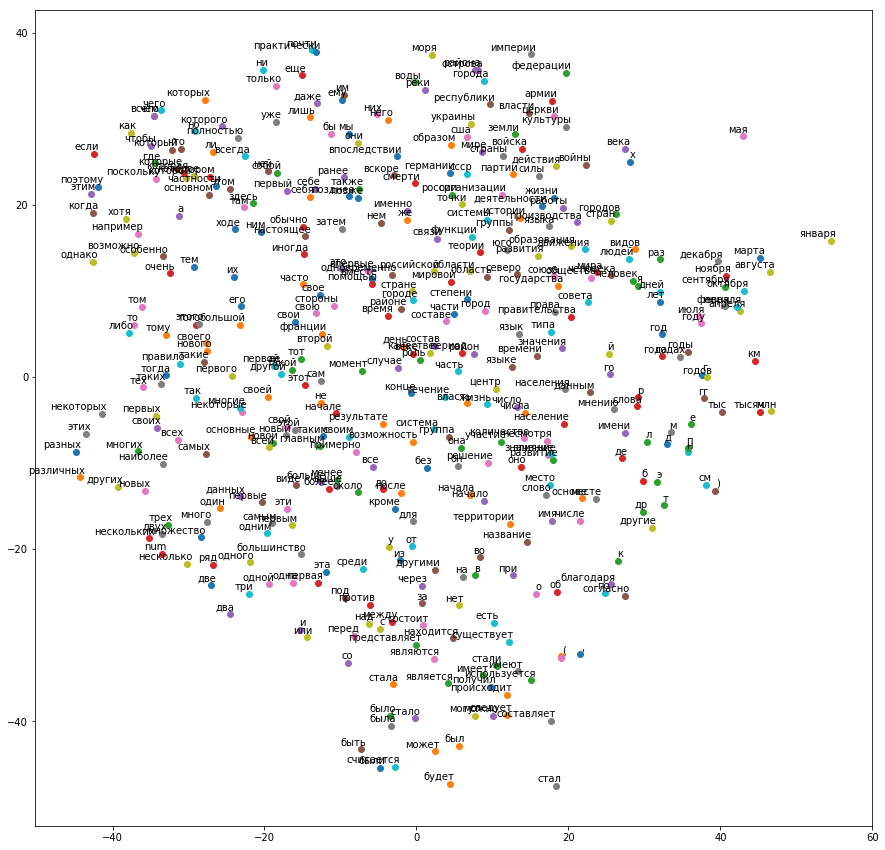

In [7]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)